In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from collections import OrderedDict
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_aisles = pd.read_csv('aisles.csv')
df_departments = pd.read_csv('departments.csv')
df_order_products_prior = pd.read_csv('order_products__prior.csv')
df_order_products_train = pd.read_csv('order_products__train.csv')
df_orders = pd.read_csv('orders.csv')
df_products = pd.read_csv('products.csv')

In [3]:
df_order_products_prior.shape

(32434489, 4)

In [4]:
df_order_products_train.shape

(1384617, 4)

In [5]:
df_orders.shape

(3421083, 7)

# Subsetting Data 10% of df_orders

In [6]:
def get_subset_data(df, test_size=.1, seed=24):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() #gets list of total unique users
    test_users = rs.choice(total_users, #creates list of test users which is 10% of total unique users, randomly
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

#     df_tr = df[~df['user_id'].isin(test_users)] #creates df_tr from df_X that is not in test_users list
    df_subset = df[df['user_id'].isin(test_users)]  #creates df_te from df_X that is in test_users list
    
    return df_subset

In [7]:
df_orders = get_subset_data(df_orders)

In [8]:
df_order_products_prior = df_order_products_prior.merge(df_orders.drop('eval_set', axis = 1), on = 'order_id')
df_order_products_train = df_order_products_train.merge(df_orders.drop('eval_set', axis = 1), on = 'order_id')

In [9]:
df_order_products_prior.shape

(3216994, 9)

In [10]:
df_order_products_train.shape

(140747, 9)

In [11]:
df_orders.shape

(340378, 7)

In [12]:
# This is outdated. Going to merge on SUBSET now.
# #merge order history information with user's order product information
# df_order_products_prior = df_order_products_prior.merge(df_orders.drop('eval_set', axis = 1), on = 'order_id')
# df_order_products_train = df_order_products_train.merge(df_orders.drop('eval_set', axis = 1), on = 'order_id')

# First feature engineering (user/product total orders)

In [13]:
#grouping prior order product information by product and user id, to count how many unique user/product combinations
#tells us how many times that user ordered that product
#creates df_X which filters to have only the users found in the trian data
df_user_product = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = df_order_products_train['user_id'].unique() 
df_X = df_user_product[df_user_product['user_id'].isin(train_ids)]
df_X.head()

,product_id,user_id,user_product_total_orders
0,1,1494,3
1,1,3010,1
5,1,10315,1
6,1,11119,1
7,1,12892,1


In [14]:
#creates train_carts dataframe which groups on user id and has all products found in current cart AKA 'latest cart'
train_carts = (df_order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

In [15]:
train_carts.head()

,user_id,latest_cart
0,59,"{22912, 40545, 10082, 4472, 44408, 34949, 4720..."
1,103,{13225}
2,109,"{35042, 30406, 47144, 6473, 5450, 26477, 21936..."
3,163,"{22721, 16610, 26981, 12391, 14036, 47766, 362..."
4,164,"{34905, 10212, 2086, 39721, 4942, 21903, 35121..."


In [16]:
#merges df_X and train_carts, and creates our target label which is 1 if the product is in the users current cart
df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,1494,3,{44560},0
1,130,1494,2,{44560},0
2,397,1494,1,{44560},0
3,881,1494,1,{44560},0
4,1004,1494,2,{44560},0


# Turning to EDA and Baselining

0    0.901262
1    0.098738
Name: in_cart, dtype: float64


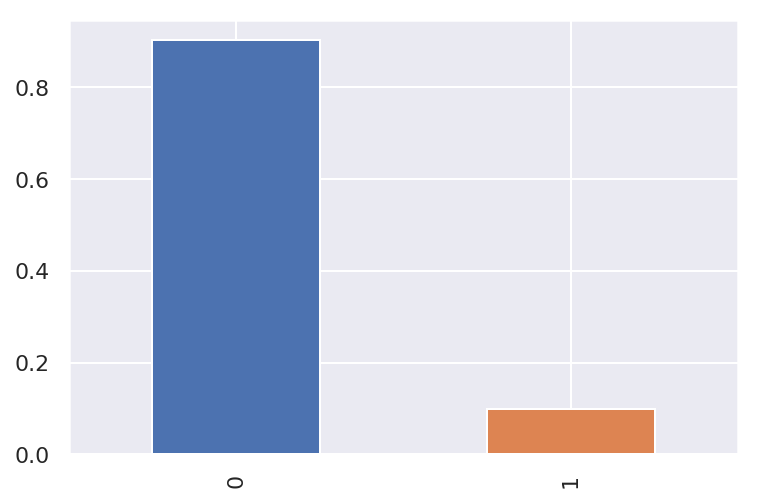

In [17]:
#check distribution for target. Result = IMBALANCED CLASSIFICATION TASK
target_pcts = df_X.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

In [18]:
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,1494,3,{44560},0
1,130,1494,2,{44560},0
2,397,1494,1,{44560},0
3,881,1494,1,{44560},0
4,1004,1494,2,{44560},0


# SEABORN PAIRPLOT

In [19]:
#feature-target relationships
#user_product_total_orders, higher values have slightly higher liklihood of a positive target
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

# plot_features(df_X)

# SPLIT SAMPLE DATA

In [20]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() #gets list of total unique users
    test_users = rs.choice(total_users, #creates list of test users which is 20% of total unique users, randomly
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)] #creates df_tr from df_X that is not in test_users list
    df_te = df[df['user_id'].isin(test_users)]  #creates df_te from df_X that is in test_users list
   
    y_tr, y_te = df_tr['in_cart'], df_te['in_cart'] #creates target train and test
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) #creates feature list to only include user_product_total_orders
    X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) #same for test
    
    return X_tr, X_te, y_tr, y_te

In [21]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

# Logistic Regression Baseline Model

In [22]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

0.08444659048232202

In [23]:
lr.coef_

array([[0.14635276]])

confirms our visual-driven assumption that a higher number of past product orders is associated with higher likelihood of being in the next cart.

# Feature Engineering to improve our model

# Product features

In [24]:
#creating column headers
prod_features = ['product_total_orders','product_avg_add_to_cart_order']
#grouping history by product to calculate sum of unique orders(counting total orders of that product)
#and mean of priority (add to cart order)
df_prod_features = (df_order_products_prior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features
df_prod_features.head()

,product_id,product_total_orders,product_avg_add_to_cart_order
0,1,195,5.579487
1,2,6,6.333333
2,3,12,4.833333
3,4,31,8.516129
4,6,1,26.000000


In [25]:
df_X = df_X.merge(df_prod_features, on='product_id')
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order
0,1,1494,3,{44560},0,195,5.579487
1,1,3010,1,"{26088, 20940, 26348, 32689, 6008, 13176}",0,195,5.579487
2,1,10315,1,{21386},0,195,5.579487
3,1,11119,1,"{17122, 8803, 43352, 41400, 5769, 14477, 21903...",0,195,5.579487
4,1,12892,1,"{43136, 5161, 17720}",0,195,5.579487


In [26]:
# plot_features(df_X)

In [27]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0983745433366866

# User features

check if our users have made many or few orders, the average number of products they buy in an order, how many different products they've bought over time, and how long they typically wait between orders. 

In [28]:
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

df_user_features = (df_order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(    #number of orderid(total products user bought) / (total orders)
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

df_user_features.columns = ['user_id'] + user_features
df_user_features.head()

,user_id,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,4,5,3.6,17,15.357143
1,20,4,5.5,7,5.500000
2,22,15,4.6,34,11.952381
3,25,3,7.0,19,30.000000
4,59,10,9.2,60,18.126582


In [29]:
df_X = df_X.merge(df_user_features, on='user_id')
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,6.283582


In [30]:
df_X.shape

(856270, 11)

In [31]:
# df_X = df_X.dropna() # note that this is naive NaN handling for simplicity

In [32]:
# plot_features(df_X)

In [33]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.14347423634680653

# User-Product features

In [34]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 
df_user_prod_features.head()

,product_id,user_id,user_product_avg_add_to_cart_order
0,1,1494,12.666667
1,1,3010,11.000000
2,1,4122,1.000000
3,1,7275,6.000000
4,1,8723,2.000000


In [35]:
df_X = df_X.merge(df_user_prod_features,on=['user_id','product_id'])

In [36]:
df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,6.283582,12.666667,0.230769


In [37]:
# plot_features(df_X)

As a hint about model selection for this problem, think about the geometric structure of the relationships above. Do they really look very linear? Our EDA already suggests that nonlinear models may do better.

In [38]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.23543299650580793

In [39]:
lr.coef_

array([[ 7.61957555e-02,  1.84350154e-05, -7.60614198e-02,
        -5.69361459e-03,  2.17355519e-02, -2.48756185e-03,
        -6.48749720e-03,  1.63925725e-03,  3.42439908e+00]])

# Additional Features

### 1. Product Reorder Prob

In [40]:
# proportion of reorder for product (probability the product is reordered)
df_prod_features1 = (df_order_products_prior.groupby(['product_id'], as_index=False)
                     .agg(OrderedDict(
                         [('reordered','sum')])))

df_prod_features1.columns = ['product_id','product_reorder_count']

In [41]:
df_X = df_X.merge(df_prod_features1, on='product_id')
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,product_reorder_count
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,6.283582,12.666667,0.230769,110


In [42]:
df_X['product_reorder_prob'] = df_X['product_reorder_count'] / df_X['product_total_orders']
df_X = df_X.drop(columns = 'product_reorder_count')

In [43]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.23943265076084916

### 2. Product Reorder Prob (excluding first order)

In [44]:
df_no_null = df_order_products_prior.dropna()
df_no_null.head(1)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,6,40462,1,0,22352,4,1,12,30.0


In [45]:
df_no_null = pd.DataFrame(df_no_null.groupby('product_id')['days_since_prior_order'].count())

In [46]:
# proportion of reorder for product (probability the product is reordered)
df_prod_features2 = pd.DataFrame(df_order_products_prior.groupby(['product_id'])['reordered'].sum())

In [47]:
df_prod_features2 = df_prod_features2.merge(df_no_null, on='product_id')
df_prod_features2.shape

(40760, 2)

In [48]:
df_prod_features2['product_reorder_prob_x_first'] = df_prod_features2['reordered'] / df_prod_features2['days_since_prior_order']

In [49]:
df_prod_features2 = df_prod_features2.drop(columns = ['reordered','days_since_prior_order'])

In [50]:
df_X = df_X.merge(df_prod_features2, on='product_id')
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,product_reorder_prob,product_reorder_prob_x_first
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,6.283582,12.666667,0.230769,0.564103,0.601093


In [51]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.1873662203195779

### 3. Adding department information (dummy variables)

In [52]:
df_merged_departments = df_products.merge(df_departments, on='department_id')

In [53]:
df_merged_departments = df_merged_departments.drop(columns = ['product_name','aisle_id','department_id'])
df_merged_departments.head(1)

,product_id,department
0,1,snacks


In [54]:
df_merged_departments = pd.get_dummies(df_merged_departments)

In [55]:
df_X = df_X.merge(df_merged_departments, on='product_id')

In [56]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.21792771084337348

### 4. Organic vs Non-organic

In [57]:
df_product_organic = df_products

In [58]:
df_product_organic['product'] = 0

In [59]:
df_product_organic['product'][df_product_organic['product_name'].str.contains('Organic')] = "organic"

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [60]:
df_product_organic['product'][df_product_organic['product_name'].str.contains('ORGANIC')] = "organic"

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [61]:
df_product_organic['product'][~df_product_organic['product_name'].str.contains('Organic')] = "xorganic"

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [62]:
df_product_organic = df_product_organic.drop(columns = ['department_id','aisle_id','product_name'])

In [63]:
df_product_organic = pd.get_dummies(df_product_organic)

In [64]:
df_X = df_X.merge(df_product_organic, on='product_id')

In [65]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.23420953101361575

### defining an organic user

In [66]:
df_user_organic = df_order_products_prior.merge(df_products, on = 'product_id')

In [67]:
df_user_organic['product'] = np.where(df_user_organic['product']=='organic', 1,0)

In [68]:
df_user_organic_feature = df_user_organic.groupby('user_id').agg({'product':'sum','order_id':'count'})

In [69]:
df_user_organic_feature['user_organic_percent'] = df_user_organic_feature['product'] / df_user_organic_feature['order_id']

In [70]:
# Using Dummies for user_organic instead of percent

# df_user_organic_feature['user_organic'] = np.where(df_user_organic_feature['user_organic_percent']>=.5,'organic','x_organic')
# df_user_organic_feature = df_user_organic_feature.drop(columns = ['product_organic','order_id','user_organic_percent'])
# df_user_organic_feature = pd.get_dummies(df_user_organic_feature)

In [71]:
df_user_organic_feature = df_user_organic_feature.drop(columns = ['product','order_id'])

In [72]:
df_X = df_X.merge(df_user_organic_feature, on = 'user_id')

In [73]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.2371828068358364

### 5. Add another user-product feature that computes how many orders it's been since the user ordered that product 

In [75]:
df_test = pd.DataFrame(df_order_products_prior.groupby(['product_id','user_id','order_number'])['order_number'].mean())

In [76]:
df_test.head()

order_number
product_id user_id order_number              
1          1494    6                        6
                   7                        7
                   9                        9
           3010    5                        5
           4122    11                      11

In [77]:
df_test.columns = ['order_number2']

In [78]:
df_test = df_test.reset_index()

In [79]:
df_test.head()

,product_id,user_id,order_number,order_number2
0,1,1494,6,6
1,1,1494,7,7
2,1,1494,9,9
3,1,3010,5,5
4,1,4122,11,11


In [80]:
df_test['order_number2'] = (df_test.groupby(['product_id','user_id'])['order_number'].transform(lambda grp:grp.shift(1)))

In [81]:
df_test['user_product_order_num_diff'] = df_test['order_number'] - df_test['order_number2']

In [82]:
df_test2 = df_test.drop(columns = ['order_number','order_number2'])

In [83]:
df_test3 = pd.DataFrame(df_test2.groupby(['product_id','user_id'])['user_product_order_num_diff'].max())

In [84]:
df_test4 = df_test3.reset_index()

In [85]:
df_X = df_X.merge(df_test4,on=['user_id','product_id'])

# Random Forest

In [86]:
df_X['user_product_order_num_diff'] = df_X['user_product_order_num_diff'].fillna(-999)

X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100,min_samples_split=50)
rf.fit(X_tr, y_tr)
print(recall_score(y_tr,rf.predict(X_tr)))
print(precision_score(y_tr,rf.predict(X_tr)))
print(f1_score(y_tr,rf.predict(X_tr)))

print('\n')

print(recall_score(y_te,rf.predict(X_te)))
print(precision_score(y_te,rf.predict(X_te)))
print(f1_score(y_te,rf.predict(X_te)))

0.18355451008240498
0.8195389391637492
0.2999323115602185


0.12983947119924458
0.6134969325153374
0.2143205065757428


In [87]:
# plot_features(df_X)

### 6.Add another user-product feature that computes the % of times a product shows up consecutively in the user's orders
### (i.e. they reordered it immediately in the next order)

In [88]:
df6_a = df_test.groupby(['product_id','user_id'])['user_product_order_num_diff'].apply(lambda x: (x==1).sum()).reset_index(name='consec')
df6_b = df_test.groupby(['product_id','user_id'])['user_product_order_num_diff'].apply(lambda x: (x>=0).sum()).reset_index(name='total')

In [89]:
df6_final = df6_a.merge(df6_b, on = ['product_id','user_id'])

In [90]:
df6_final['user_product_cons_perc'] = df6_final['consec']/df6_final['total']

In [91]:
df6_final2 = df6_final.drop(columns = ['consec','total'])

In [92]:
df_X = df_X.merge(df6_final2,on=['user_id','product_id'])

In [93]:
df_X['user_product_cons_perc'] = df_X['user_product_cons_perc'].fillna(-9999)

In [94]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100,min_samples_split=50, class_weight={1:9,0:1})


rf.fit(X_tr, y_tr)
print(recall_score(y_tr,rf.predict(X_tr)))
print(precision_score(y_tr,rf.predict(X_tr)))
print(f1_score(y_tr,rf.predict(X_tr)))

print('\n')

print(recall_score(y_te,rf.predict(X_te)))
print(precision_score(y_te,rf.predict(X_te)))
print(f1_score(y_te,rf.predict(X_te)))

0.8121994881126744
0.5038084575288158
0.6218700619049506


0.48170443814919733
0.32250671724355934
0.3863485752153744


### 7. Using Order Time / Day of Week

In [96]:
# merging product_time
df_product_time = df_order_products_prior.groupby('product_id')['order_dow','order_hour_of_day'].mean().reset_index()

In [97]:
df_product_time.columns = ['product_id','product_order_dow','product_order_hour']

In [98]:
df_X = df_X.merge(df_product_time, on = 'product_id')

In [99]:
# merging user_product time
df_user_product_time = df_order_products_prior.groupby(['product_id','user_id'])['order_dow','order_hour_of_day'].mean().reset_index()

In [100]:
df_user_product_time.columns = ['product_id','user_id','user_product_order_dow','user_product_order_hour']

In [101]:
df_X = df_X.merge(df_user_product_time, on = ['product_id','user_id'])

# Saving ML Dataframe

In [102]:
#Saving our ML dataframe with features for future use:
df_X.to_csv('instacart_df_X_features.csv', index=False)

In [103]:
# df_X = pd.read_csv('instacart_df_X_features.csv')

In [104]:
df_X.shape

(855812, 45)

In [105]:
df_order_products_prior.shape

(3216994, 9)

In [106]:
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,department_snacks,product_organic,product_xorganic,user_organic_percent,user_product_order_num_diff,user_product_cons_perc,product_order_dow,product_order_hour,user_product_order_dow,user_product_order_hour
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,...,1,0,1,0.050633,2.0,0.5,2.779487,13.189744,3.333333,8.666667


In [107]:
df_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,6,40462,1,0,22352,4,1,12,30.0
1,6,15873,2,0,22352,4,1,12,30.0
2,6,41897,3,0,22352,4,1,12,30.0
3,12,30597,1,1,152610,22,6,8,10.0
4,12,15221,2,1,152610,22,6,8,10.0


In [108]:
# Then add features of the form user_product_avg_hod_delta that take the dif of the current order time and the avg
# df_user_prod_delta1 = df_order_products_prior.groupby(['user_id','product_id','order_id'])['order_dow','order_hour_of_day'].mean().reset_index()

In [109]:
df_delta = df_order_products_train.groupby(['user_id'])['order_dow','order_hour_of_day'].mean().reset_index()

In [110]:
df_X.shape

(855812, 45)

In [111]:
df_X2 = df_X.merge(df_delta, on = 'user_id')

In [112]:
df_X2['user_product_avg_hod_delta'] = df_X2['order_hour_of_day'] - df_X2['user_product_order_hour'] 

In [113]:
df_X2['user_product_avg_dow_delta'] = df_X2['order_dow'] - df_X2['user_product_order_dow']

In [114]:
df_X3 = df_X2.drop(columns = ['product_order_dow','product_order_hour'])
# df_X3 = df_X2.copy(deep=True)

In [115]:
df_X3['abs_user_prod_avg_hod_delta'] = df_X3['user_product_avg_hod_delta'].abs()
df_X3['abs_user_product_avg_dow_delta'] = df_X3['user_product_avg_dow_delta'].abs()

In [116]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X3)

rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100,min_samples_split=50, class_weight={1:9,0:1})


rf.fit(X_tr, y_tr)
print(recall_score(y_tr,rf.predict(X_tr)))
print(precision_score(y_tr,rf.predict(X_tr)))
print(f1_score(y_tr,rf.predict(X_tr)))

print('\n')

print(recall_score(y_te,rf.predict(X_te)))
print(precision_score(y_te,rf.predict(X_te)))
print(f1_score(y_te,rf.predict(X_te)))

0.8210909413696684
0.5412363593809426
0.652419241077726


0.4548512747875354
0.3343310775637689
0.3853885388538854


### 8. So far the way we've used the order history treats the entire history on equal terms - for example, user-product order frequency treats orders from months ago the same as recent ones. Come up with features that focus more on the most recent orders or give them more weight than older ones.

In [117]:
#user_product orders
df_user_percent = df_order_products_prior.groupby('user_id')['order_number'].max().reset_index()
df_user_percent.columns = ['user_id','user_order_num_max']
df_user_percent.head()

,user_id,user_order_num_max
0,4,5
1,20,4
2,22,15
3,25,3
4,59,10


In [118]:
df_user_percent2 = df_order_products_prior.merge(df_user_percent, on = 'user_id')

In [119]:
df_user_percent2['user_order_num_perc'] = df_user_percent2['order_number'] / df_user_percent2['user_order_num_max']

In [120]:
df_user_percent2 = df_user_percent2.groupby(['user_id','product_id'])['user_order_num_perc'].max().reset_index()

In [121]:
df_X = df_X3.merge(df_user_percent2, on =['user_id','product_id'])

In [122]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100,min_samples_split=50, class_weight={1:9,0:1})


rf.fit(X_tr, y_tr)
print(recall_score(y_tr,rf.predict(X_tr)))
print(precision_score(y_tr,rf.predict(X_tr)))
print(f1_score(y_tr,rf.predict(X_tr)))

print('\n')

print(recall_score(y_te,rf.predict(X_te)))
print(precision_score(y_te,rf.predict(X_te)))
print(f1_score(y_te,rf.predict(X_te)))

0.8426168390217922
0.5415620721131903
0.6593502005660999


0.5159348441926346
0.3627385892116183
0.4259818731117825


In [123]:
#Saving our ML dataframe with features for future use:
df_X.to_csv('df_X_pre_XGB.csv', index=False)

In [124]:
# df_X = pd.read_csv('df_X_pre_XGB.csv')

# XGB

In [125]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

In [126]:
gbm = xgb.XGBClassifier(n_jobs=-1,
                       n_estimators=30000,#try 30000
                       max_depth=5,
                       objective= 'binary:logistic', #new objective
                       learning_rate=.1,# 0.05 not as good
                       subsample=1,
                       min_child_weight=4,
                       colsample_bytree=.8,
                       scale_pos_weight=4
              )

eval_set=[(X_tr,y_tr),(X_te,y_te)]
gbm.fit(
                   X_tr, y_tr,
                   eval_set=eval_set,
                   eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                   early_stopping_rounds=20, #try 20.
                   verbose=True #gives output log as below
                  )

[0]	validation_0-auc:0.813551	validation_1-auc:0.81233
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.817681	validation_1-auc:0.816313
[2]	validation_0-auc:0.819706	validation_1-auc:0.81823
[3]	validation_0-auc:0.820421	validation_1-auc:0.819028
[4]	validation_0-auc:0.822172	validation_1-auc:0.820692
[5]	validation_0-auc:0.823213	validation_1-auc:0.821435
[6]	validation_0-auc:0.823759	validation_1-auc:0.821977
[7]	validation_0-auc:0.82438	validation_1-auc:0.822462
[8]	validation_0-auc:0.824968	validation_1-auc:0.823111
[9]	validation_0-auc:0.825378	validation_1-auc:0.82347
[10]	validation_0-auc:0.825586	validation_1-auc:0.823711
[11]	validation_0-auc:0.8258	validation_1-auc:0.823924
[12]	validation_0-auc:0.826045	validation_1-auc:0.824049
[13]	validation_0-auc:0.826156	validation_1-auc:0.824044
[14]	validation_0-auc:0.826606	validation_1-auc:0.82453
[15]	

[142]	validation_0-auc:0.840507	validation_1-auc:0.828697
[143]	validation_0-auc:0.840611	validation_1-auc:0.828691
[144]	validation_0-auc:0.840674	validation_1-auc:0.828686
[145]	validation_0-auc:0.840746	validation_1-auc:0.828676
[146]	validation_0-auc:0.840779	validation_1-auc:0.828675
[147]	validation_0-auc:0.840833	validation_1-auc:0.828651
[148]	validation_0-auc:0.840897	validation_1-auc:0.828657
[149]	validation_0-auc:0.840972	validation_1-auc:0.828661
[150]	validation_0-auc:0.841053	validation_1-auc:0.828656
[151]	validation_0-auc:0.841099	validation_1-auc:0.828659
[152]	validation_0-auc:0.841156	validation_1-auc:0.828627
[153]	validation_0-auc:0.84122	validation_1-auc:0.828642
[154]	validation_0-auc:0.841293	validation_1-auc:0.828637
[155]	validation_0-auc:0.841387	validation_1-auc:0.828637
[156]	validation_0-auc:0.841449	validation_1-auc:0.828652
[157]	validation_0-auc:0.841527	validation_1-auc:0.828663
[158]	validation_0-auc:0.841641	validation_1-auc:0.828644
[159]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=4, missing=None, n_estimators=30000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
       seed=None, silent=True, subsample=1)

In [127]:
print(f1_score(y_te,gbm.predict(X_te)))

0.4338852070137683


In [128]:
print(f1_score(y_tr,gbm.predict(X_tr)))

0.44880394098487253


# Using F1 because we want to be precise but don't care too much about missing because it's relatively cheap the market the ads

# 100 random forests

In [129]:
print(recall_score(y_tr,gbm.predict(X_tr)))
print(precision_score(y_tr,gbm.predict(X_tr)))
print(f1_score(y_tr,gbm.predict(X_tr)))

print('\n')

print(recall_score(y_te,gbm.predict(X_te)))
print(precision_score(y_te,gbm.predict(X_te)))
print(f1_score(y_te,gbm.predict(X_te)))

0.5330729513411152
0.3875408707623473
0.44880394098487253


0.5235481586402266
0.37044306176138975
0.4338852070137683


In [130]:
confusion_matrix(y_te, gbm.predict(X_te))

array([[140377,  15076],
       [  8073,   8871]])

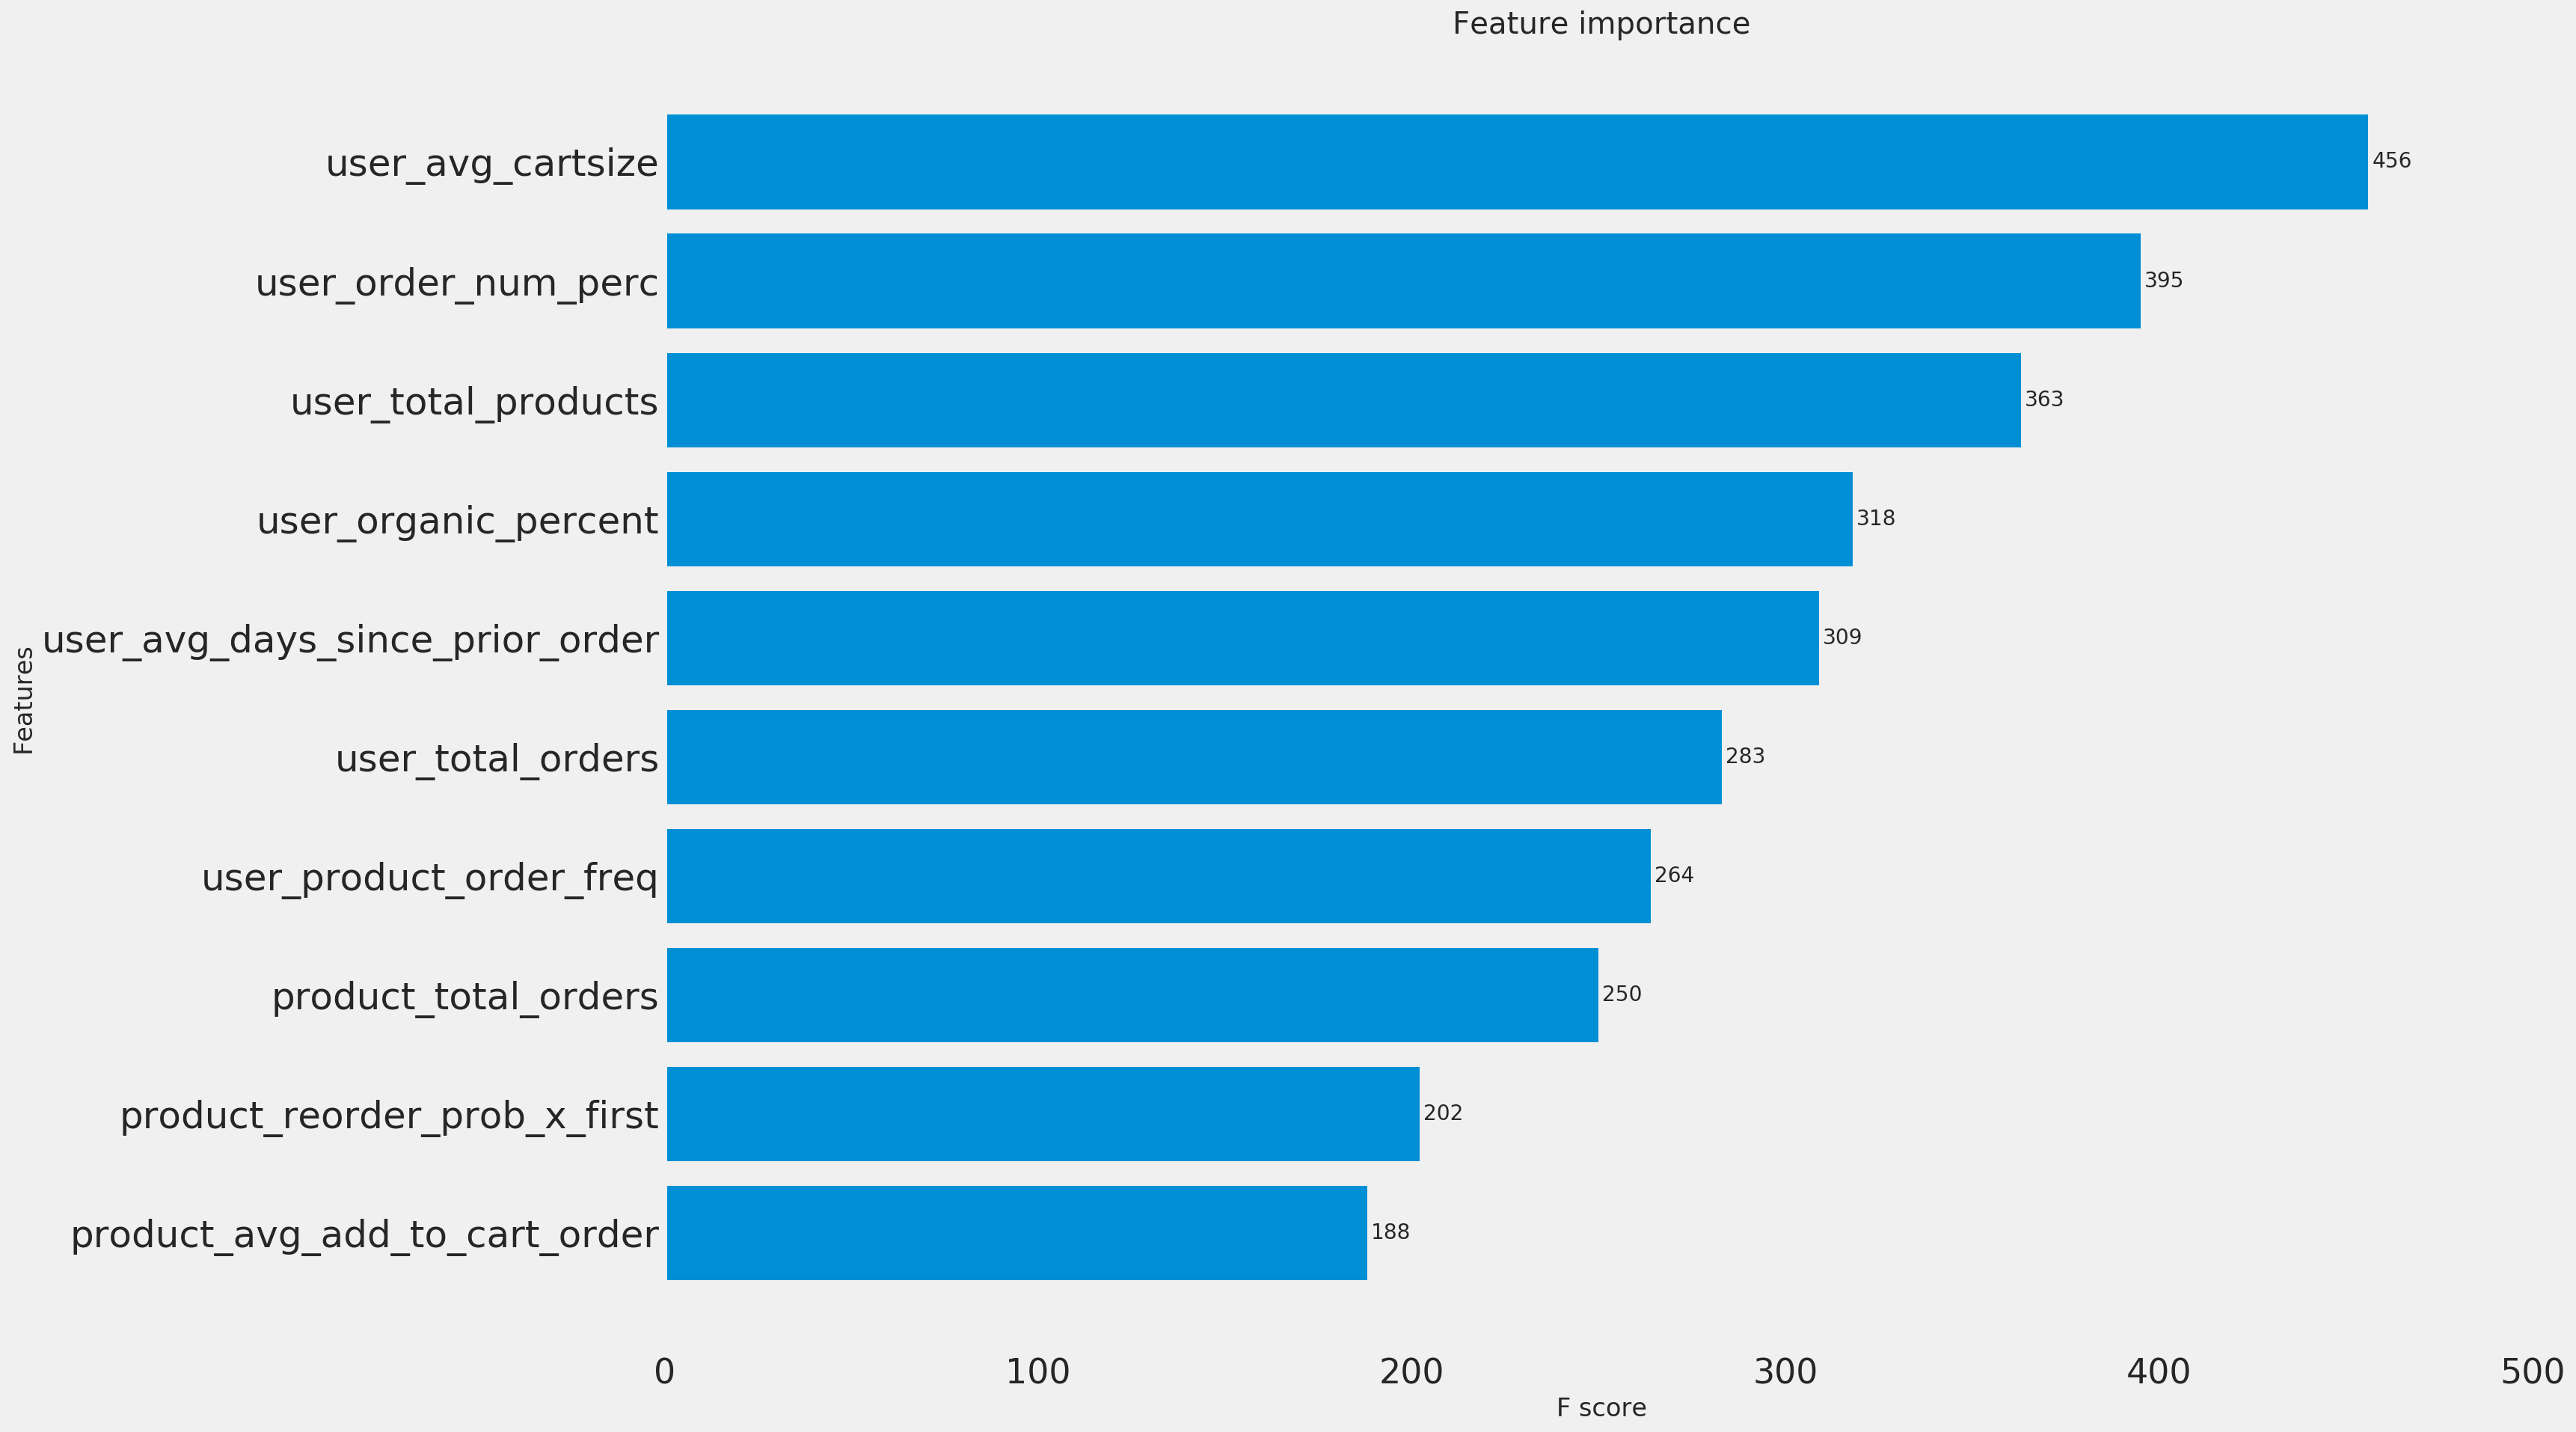

In [180]:
ax = xgb.plot_importance(gbm, max_num_features=10, height=0.8, grid = False)
fig = ax.figure
fig.set_size_inches(20, 15)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 23)
plt.savefig("NEW_SUB_GBM_Features_weight.png", bbox_inches='tight')

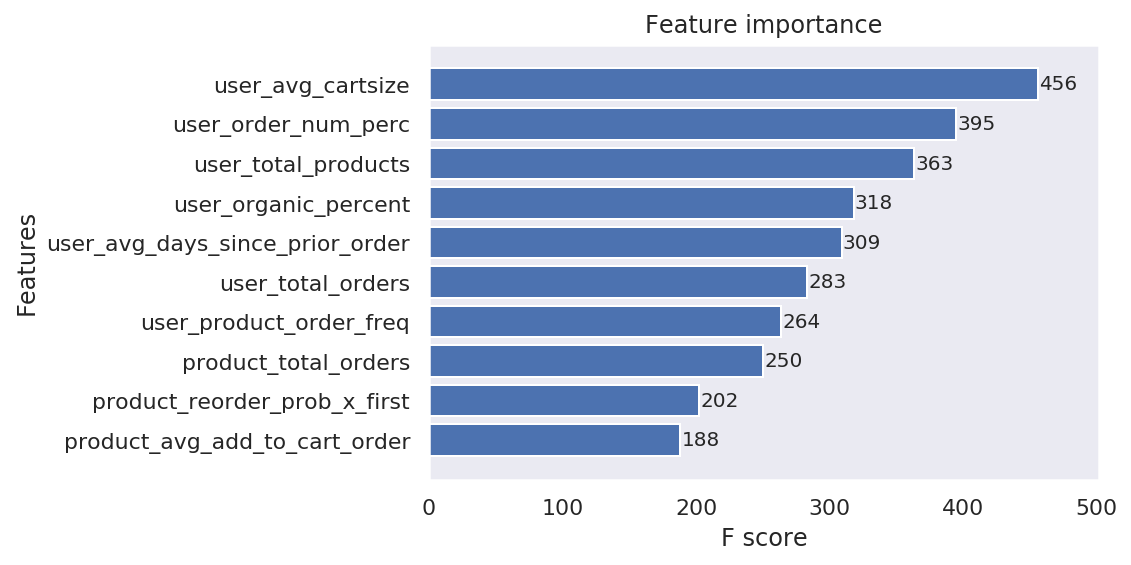

In [131]:
xgb.plot_importance(gbm, max_num_features=10, height=0.8, grid = False)
# xgb.ylabels.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig("SUB_GBM_Features_weight.png", bbox_inches='tight')

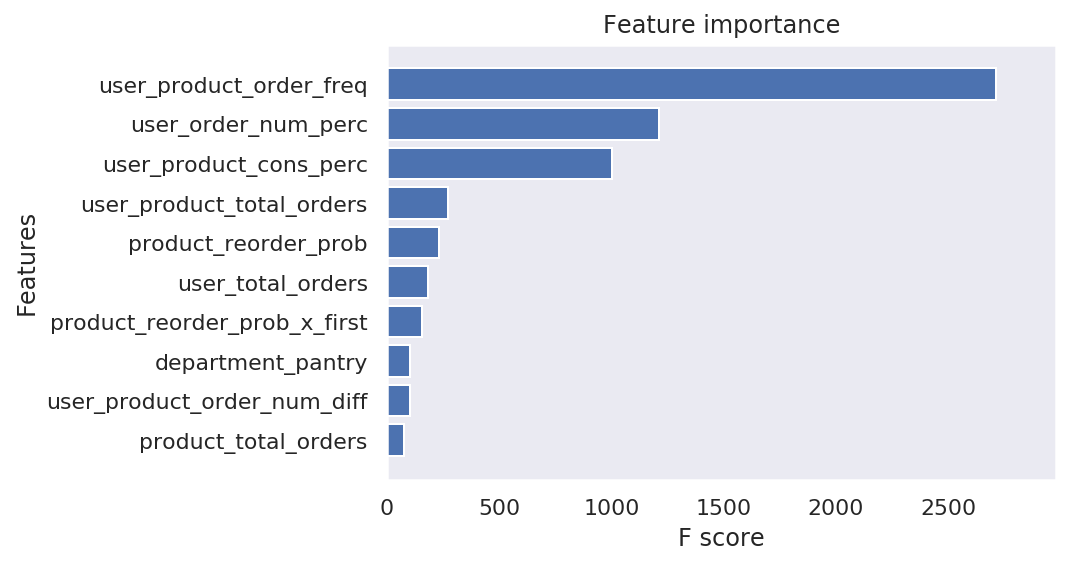

In [132]:
xgb.plot_importance(gbm, max_num_features=10, height=0.8, importance_type = 'gain', grid = False, show_values = False)
plt.savefig("SUB_GBM_Features_gain.png", bbox_inches='tight')

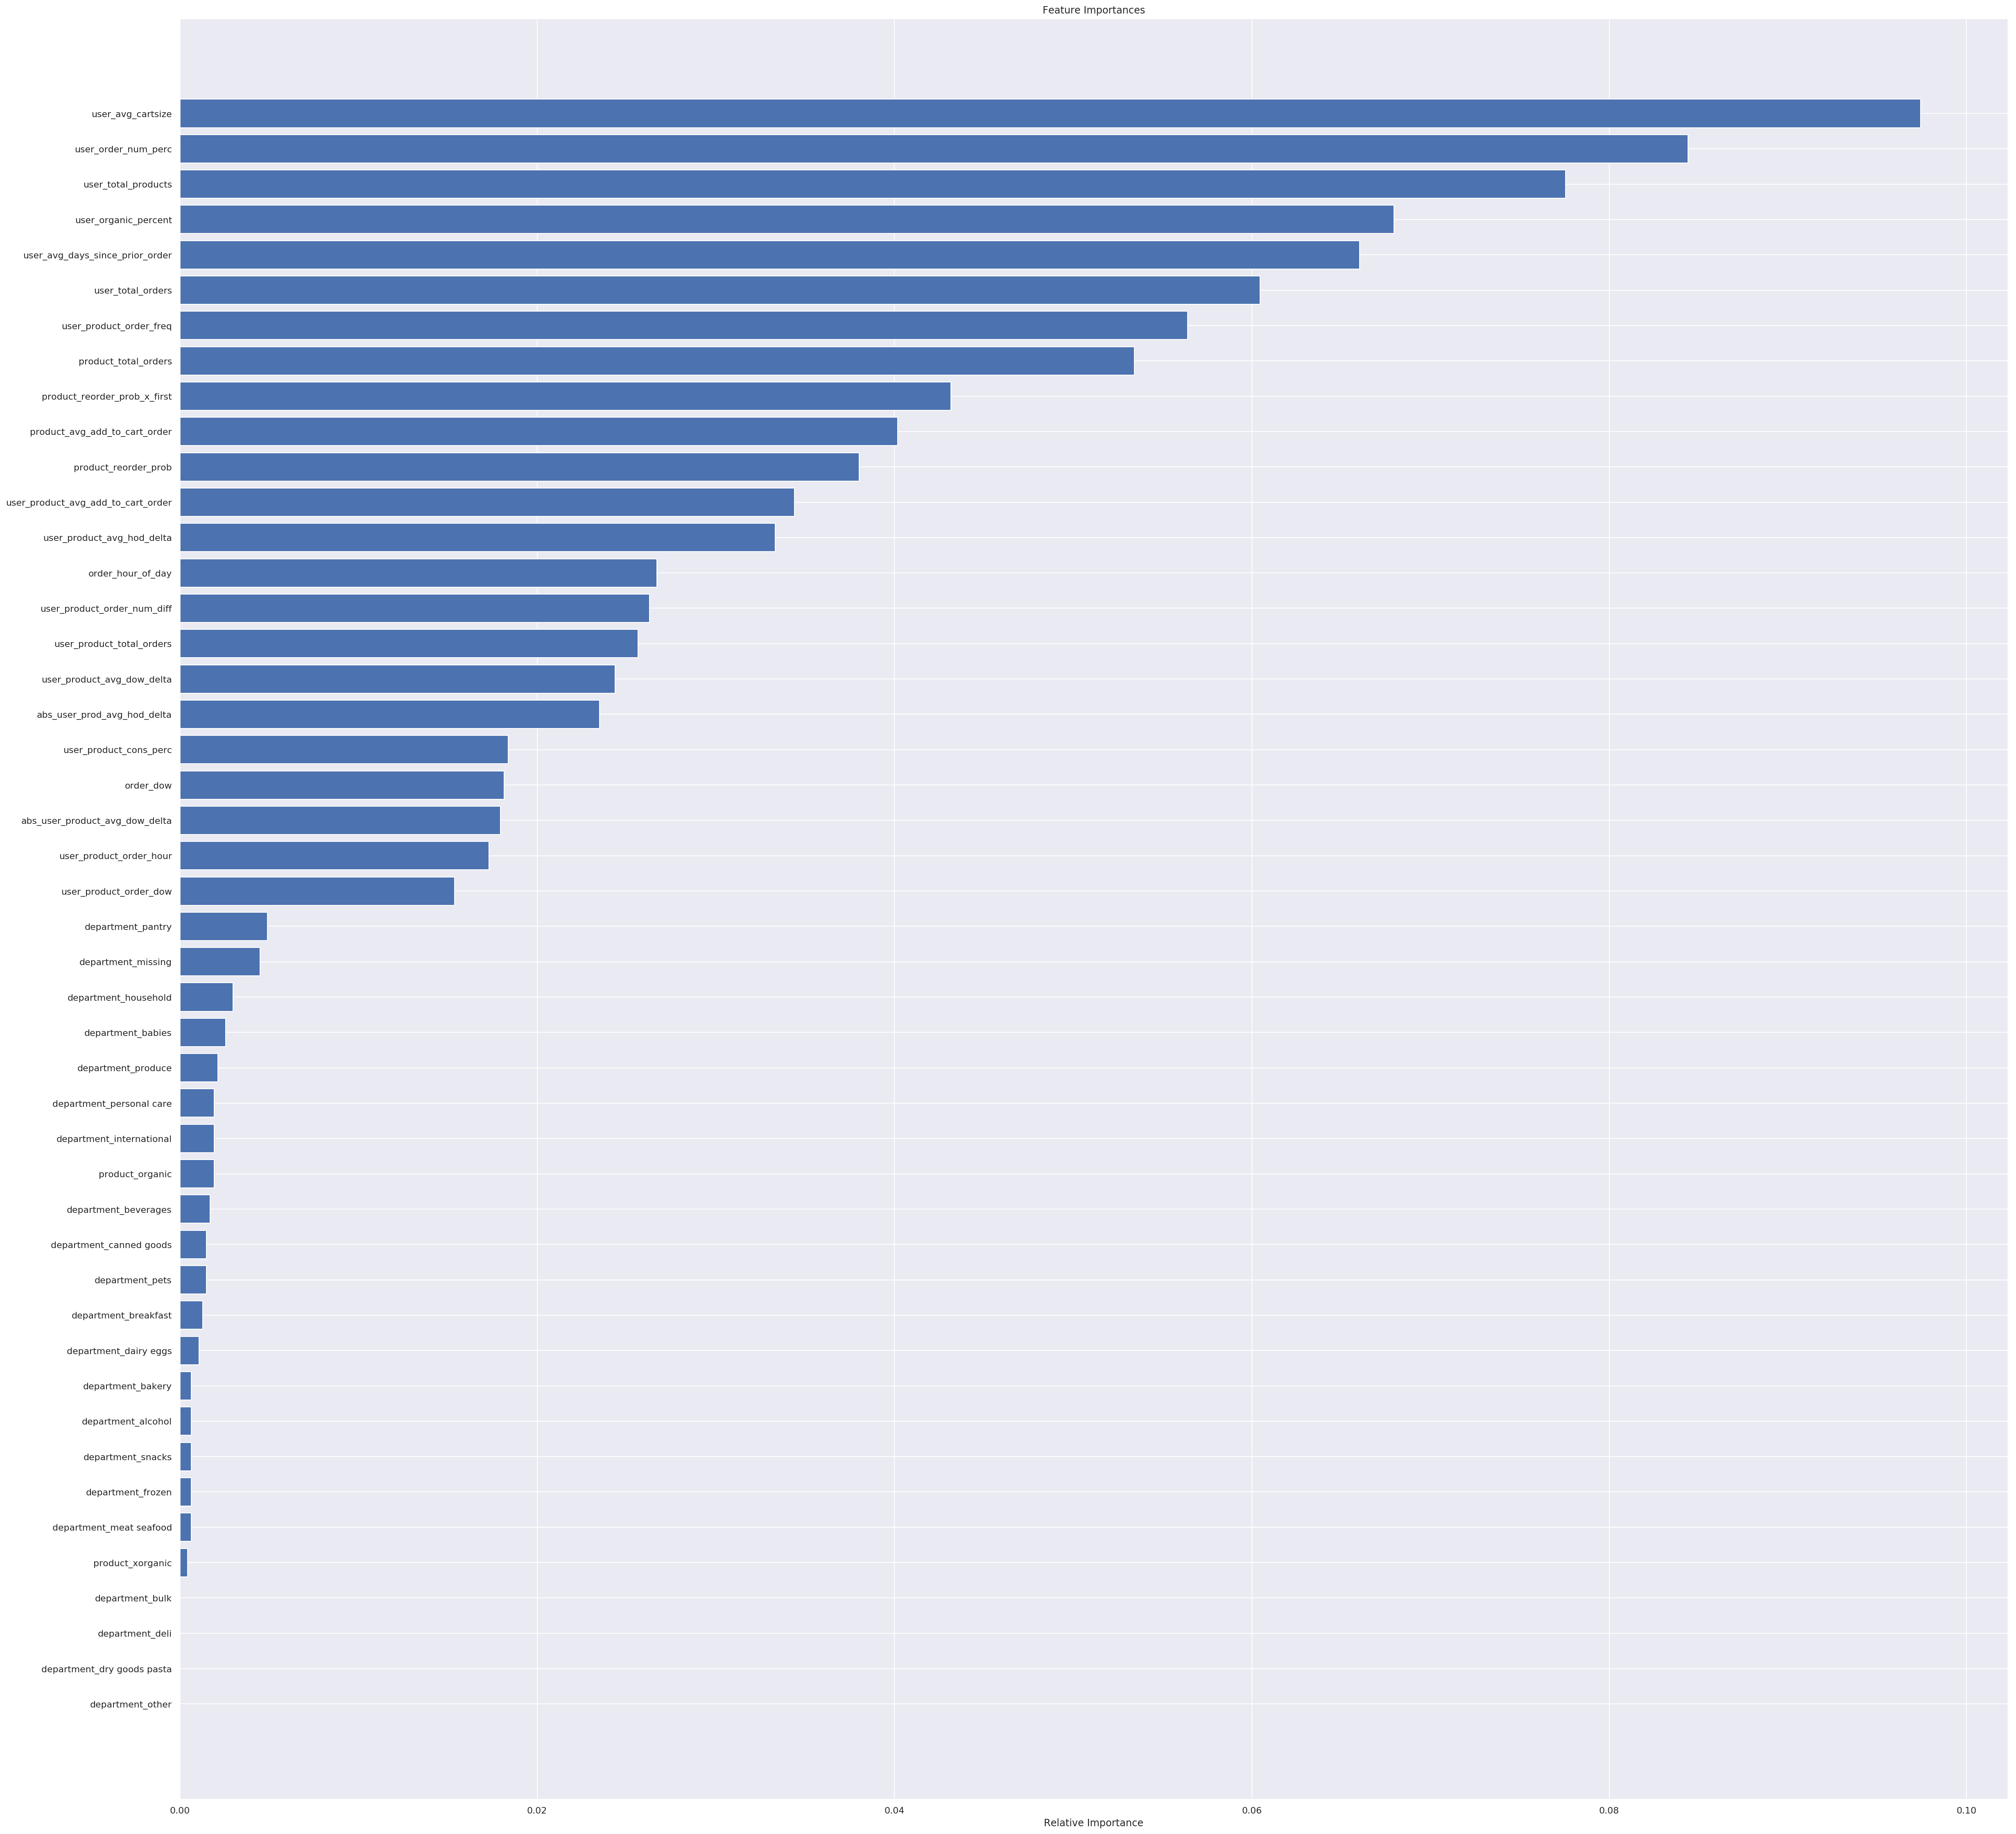

In [133]:
features = list(X_tr.columns)
importances = gbm.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(40,40))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlabel('Relative Importance')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

# plt.savefig("GBM_Features.png", bbox_inches='tight')

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


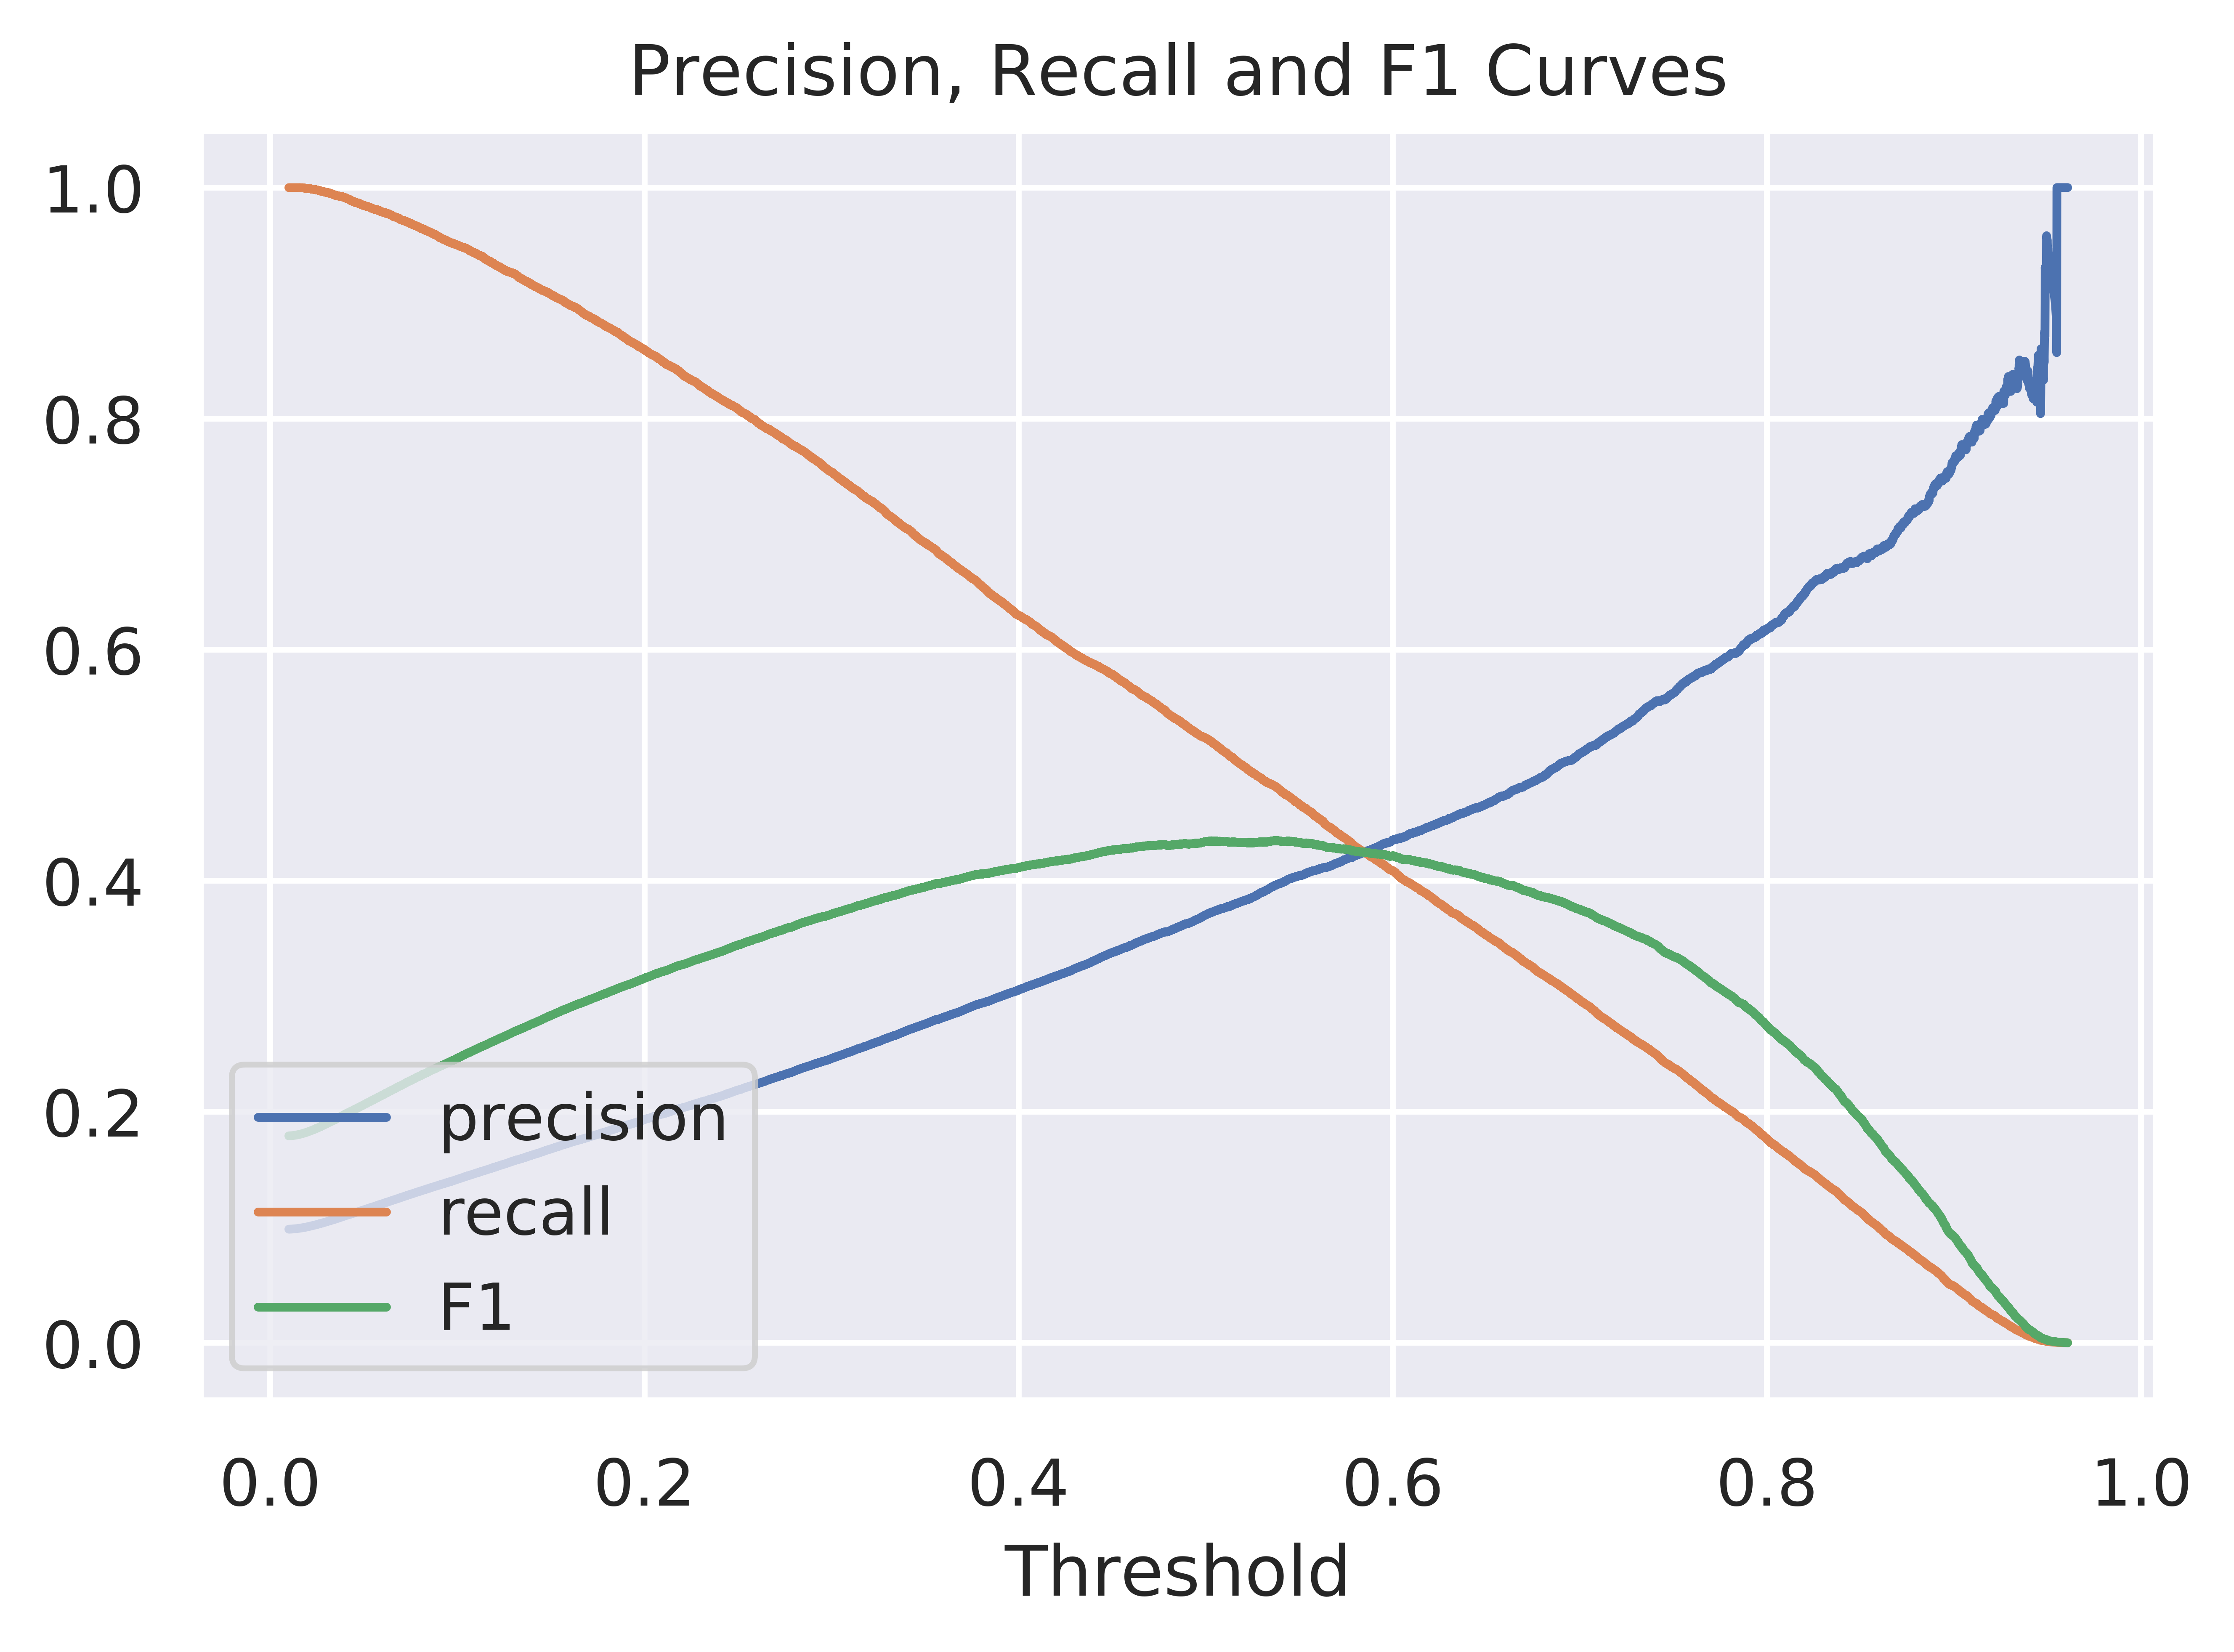

In [134]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, gbm.predict_proba(X_te)[:,1] )
f1_curve = 2/(1/recall_curve + 1/precision_curve)

plt.figure(dpi=500)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(threshold_curve, f1_curve[1:], label='F1')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision, Recall and F1 Curves');

plt.savefig("SUB_PRF_curve.png", bbox_inches='tight')

In [135]:
lr = LogisticRegression(class_weight={1:9,0:1})
lr.fit(X_tr, y_tr)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight={0: 1, 1: 9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [136]:
f1_score(y_te,lr.predict(X_te))

0.3619810107374597

In [137]:
lr_values=[]
rf_values=[]
gb_values=[]

In [138]:
lr_values.append(precision_score(y_te,lr.predict(X_te)))
lr_values.append(recall_score(y_te,lr.predict(X_te)))
lr_values.append(f1_score(y_te,lr.predict(X_te)))

rf_values.append(precision_score(y_te,rf.predict(X_te)))
rf_values.append(recall_score(y_te,rf.predict(X_te)))
rf_values.append(f1_score(y_te,rf.predict(X_te)))

gb_values.append(precision_score(y_te,gbm.predict(X_te)))
gb_values.append(recall_score(y_te,gbm.predict(X_te)))
gb_values.append(f1_score(y_te,gbm.predict(X_te)))

In [139]:
lr_values

[0.2396800183721509, 0.7391406987724268, 0.3619810107374597]

In [140]:
rf_values

[0.3627385892116183, 0.5159348441926346, 0.4259818731117825]

In [141]:
gb_values

[0.37044306176138975, 0.5235481586402266, 0.4338852070137683]

In [142]:
import matplotlib.lines as mlines
import matplotlib.style as style
style.available

style.use('fivethirtyeight')

In [143]:
df_graph = pd.DataFrame([lr_values,rf_values,gb_values])

In [144]:
df_graph.columns = ['Precision','Recall','F1']

In [145]:
df_graph = df_graph.rename({0: 'Logistic Regression', 1: 'Random Forest', 2:'Gradient Boosting'})

In [146]:
df_graph

,Precision,Recall,F1
Logistic Regression,0.239680,0.739141,0.361981
Random Forest,0.362739,0.515935,0.425982
Gradient Boosting,0.370443,0.523548,0.433885


In [147]:
bars1 = lr_values
bars2 = rf_values
bars3 = gb_values

In [148]:
barWidth = 0.25

In [149]:
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

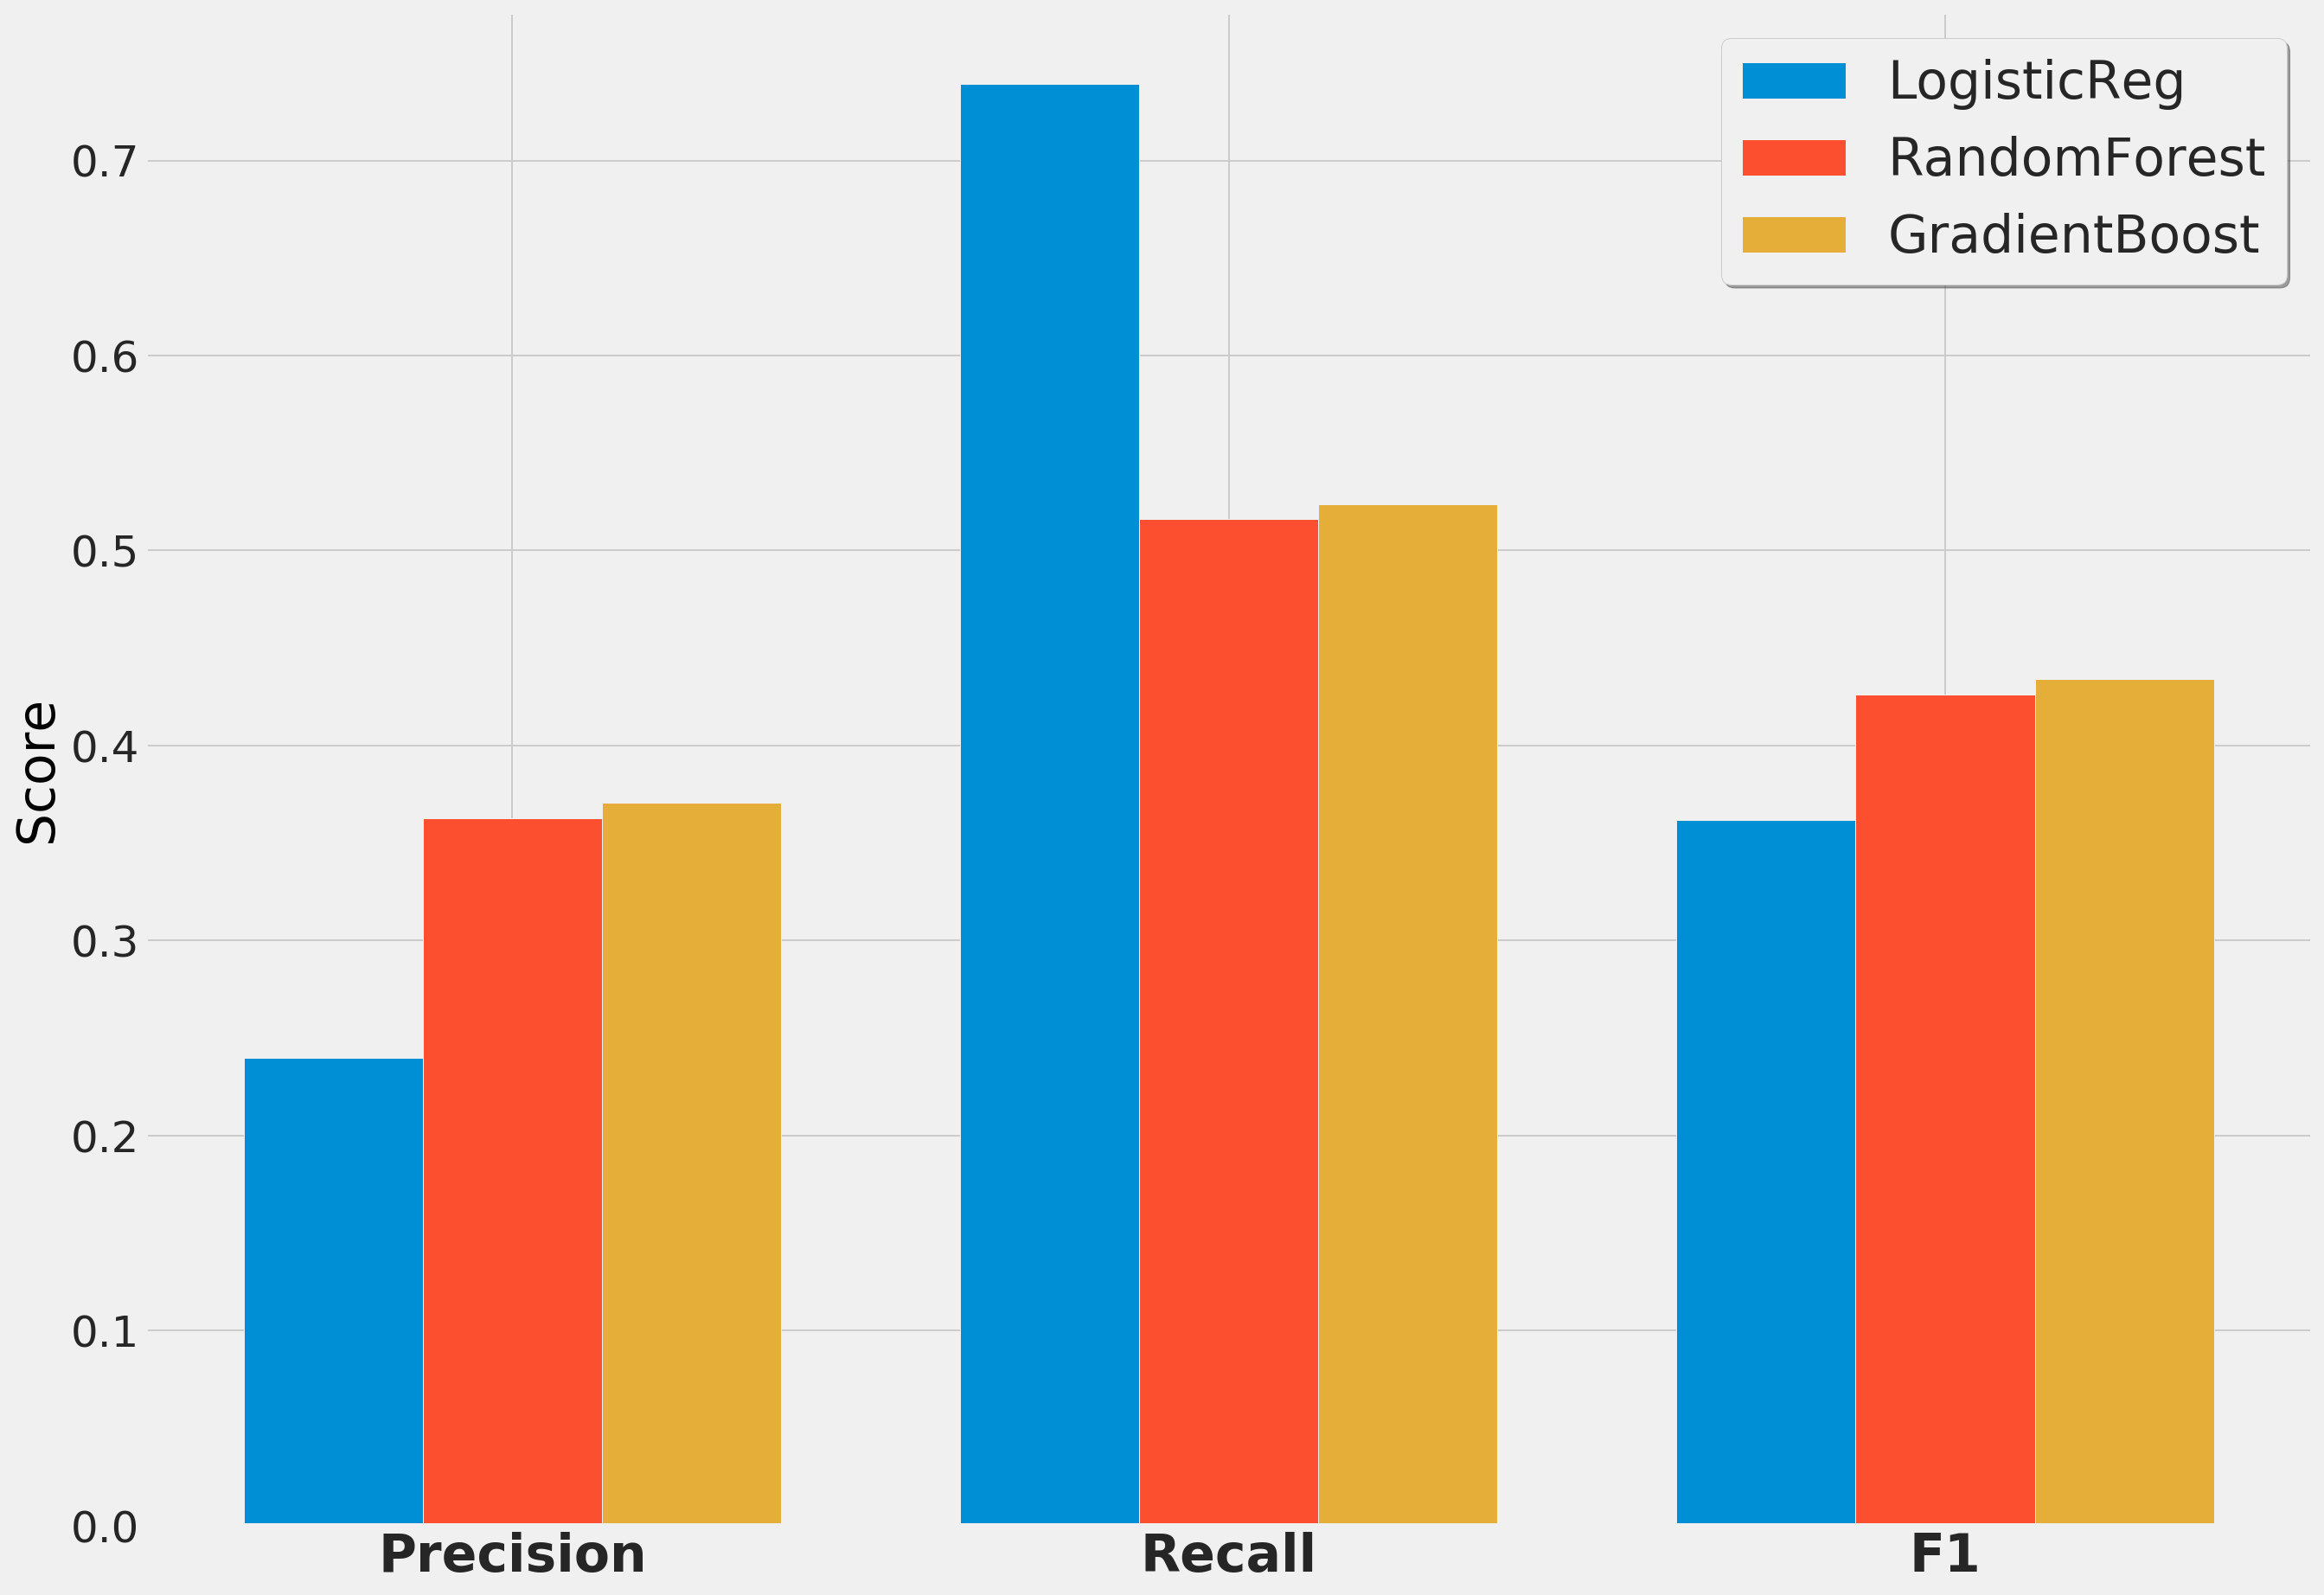

In [150]:
plt.figure(figsize=[20,15])
plt.bar(r1, bars1, width=barWidth, label='LogisticReg')
plt.bar(r2, bars2, width=barWidth, label='RandomForest')
plt.bar(r3, bars3, width=barWidth, label='GradientBoost')

plt.xticks([r + barWidth for r in range(len(bars1))], ['Precision', 'Recall', 'F1'], 
           fontsize = 30,weight='bold')
plt.yticks(fontsize = 25)
plt.ylabel('Score', fontsize=30, color='black')
plt.legend(shadow = True,loc = 1, fontsize = 30)

plt.savefig("SUB_Models.png", bbox_inches='tight')

# Making tables for Tableau Visualizations

In [151]:
df_products.shape

(49688, 5)

In [152]:
df_products2 = df_products.merge(df_departments, on = 'department_id')

In [153]:
df_products2 = df_products2.merge(df_aisles, on = 'aisle_id')

In [154]:
df_X.shape

(855812, 50)

In [155]:
df_products2 = df_products2.drop(columns = ['aisle_id','department_id'])

In [156]:
df_tab2 = df_X.merge(df_products2, on = 'product_id')

In [157]:
df_tab2

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,order_hour_of_day,user_product_avg_hod_delta,user_product_avg_dow_delta,abs_user_prod_avg_hod_delta,abs_user_product_avg_dow_delta,user_order_num_perc,product_name,product,department,aisle
0,1,1494,3,{44560},0,195,5.579487,13,12.153846,71,...,8,-0.666667,-0.333333,0.666667,0.333333,0.692308,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
1,1,3010,1,"{26088, 20940, 26348, 32689, 6008, 13176}",0,195,5.579487,13,9.615385,64,...,14,4.000000,-2.000000,4.000000,2.000000,0.384615,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
2,1,10315,1,{21386},0,195,5.579487,5,1.800000,3,...,18,2.000000,3.000000,2.000000,3.000000,0.200000,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
3,1,11119,1,"{17122, 8803, 43352, 41400, 5769, 14477, 21903...",0,195,5.579487,23,4.478261,41,...,8,-6.000000,1.000000,6.000000,1.000000,0.782609,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
4,1,12892,1,"{43136, 5161, 17720}",0,195,5.579487,19,3.473684,36,...,17,5.000000,0.000000,5.000000,0.000000,0.842105,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
5,1,18586,2,"{196, 9477, 37710}",0,195,5.579487,12,3.416667,20,...,8,-1.000000,-1.000000,1.000000,1.000000,0.916667,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
6,1,20687,1,{8958},0,195,5.579487,73,3.506849,43,...,6,-5.000000,1.000000,5.000000,1.000000,0.561644,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
7,1,21219,1,"{653, 39190, 29463, 46107, 10662, 17191, 33959...",0,195,5.579487,50,12.000000,242,...,22,10.000000,-2.000000,10.000000,2.000000,0.820000,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
8,1,24324,6,"{43459, 40709, 36551, 25513, 45321, 37178, 441...",0,195,5.579487,26,15.038462,113,...,12,-2.000000,0.666667,2.000000,0.666667,1.000000,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes
9,1,30618,3,"{37317, 46058, 22507, 8079, 12341, 4920, 28413...",0,195,5.579487,18,8.111111,24,...,9,1.333333,-3.666667,1.333333,3.666667,0.888889,Chocolate Sandwich Cookies,xorganic,snacks,cookies cakes


In [158]:
df_tab2.to_csv('df_tab2.csv', index=False)